<a href="https://colab.research.google.com/github/fedorova-av/Acoustic-Event-Detection-2025/blob/main/Fedorova_AV_HSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Путь к каталогу, в котором лежит датасет
датасет представлен файлом `train.csv` и папкой `train`

In [4]:
from google.colab import drive
import os.path as path

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
base_folder = "/content/drive/MyDrive/train"

In [7]:
# path
train_folder = path.join(base_folder, "train")
train_csv = path.join(base_folder, "train.csv")
train_pickle = path.join(base_folder, "train.pickle")
labels_pickle = path.join(base_folder, "labels.pickle")

### Изучение аудиофайлов датасета

In [8]:
import os
import random

import librosa
import librosa.feature as F_lib

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio

In [9]:
# random filename from dir
files = os.listdir(train_folder)
filename = random.choice(files)
filename

'0d65502c0e8b2abd83af.wav'

#### Спектрограмма

In [10]:
# spectrogram parameters
sample_rate = 11025

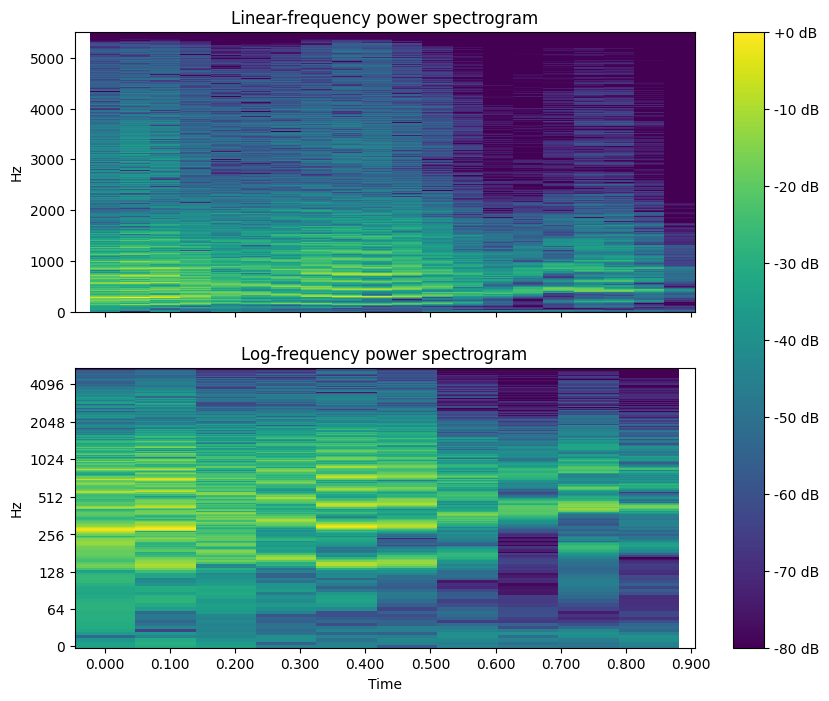

In [11]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

# draw linear-frequency spectrogram
hop_length = 512
wav_data_db = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length)),
    ref=np.max
)
img1 = librosa.display.specshow(
    wav_data_db,
    sr=sr,
    hop_length=hop_length,
    ax=ax_top,
    x_axis='time',
    y_axis='linear',
    cmap=cmap,
)
ax_top.set(title='Linear-frequency power spectrogram')
ax_top.label_outer()

# draw log-frequency spectrogram
hop_length = 1024
wav_data_db = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length)),
    ref=np.max
)
img2 = librosa.display.specshow(
    wav_data_db,
    sr=sr,
    hop_length=hop_length,
    ax=ax_bottom,
    x_axis='time',
    y_axis='log',
    cmap=cmap,
)
ax_bottom.set(title='Log-frequency power spectrogram')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

#### Mel-спектрограмма

In [12]:
# melspectrogram parameters
sample_rate = 11025
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

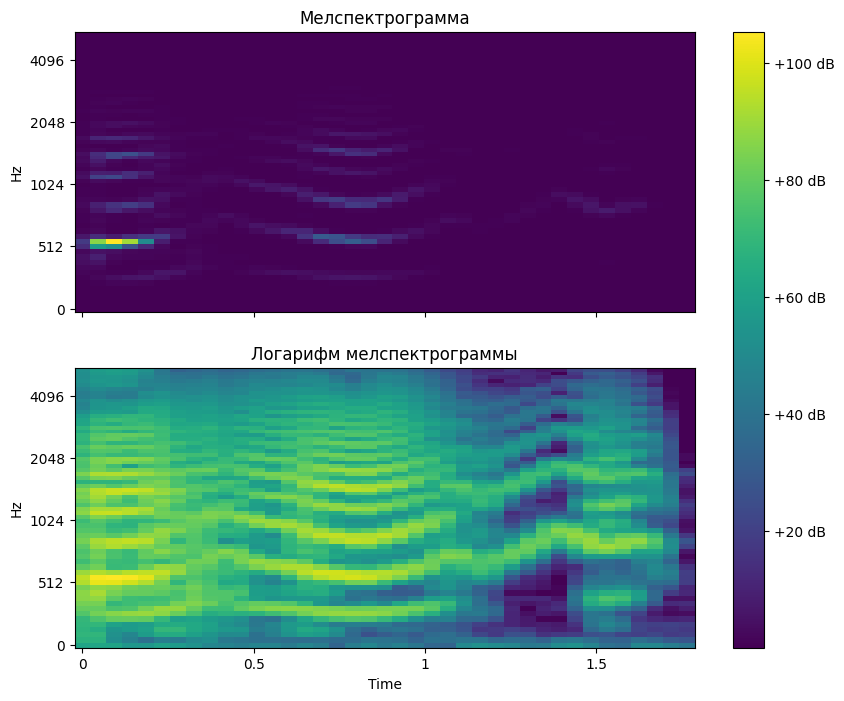

In [13]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

mel_spec = F_lib.melspectrogram(
    y=wav_data,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    fmax=sample_rate // 2
)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

img1 = librosa.display.specshow(
    mel_spec,
    sr=sr,
    fmax=sr // 2,
    ax=ax_top,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_top.set(title='Мелспектрограмма')
ax_top.label_outer()

D = librosa.power_to_db(mel_spec, ref=np.max)
img2 = librosa.display.specshow(
    D,
    sr=sr,
    fmax=sr // 2,
    ax=ax_bottom,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_bottom.set(title='Логарифм мелспектрограммы')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

## Извлечение признаков

In [14]:
import os
import pickle
from enum import Enum
from typing import NoReturn, Optional

from tqdm import tqdm

import pandas as pd
import numpy as np

import librosa
import librosa.feature as F_lib

In [15]:
class SetType(Enum):
    """Set type"""
    TRAIN = 1
    TEST  = 2
    DEV   = 3


def extract_log_mel_feats(set_type:SetType, path_to_csv:str, path_to_files:str,
                          out_path:str, labels_pickle:str, sr:Optional[int], n_fft:int,
                          hop_length:int, n_mels:int):
    """
    Extract features from given files and store them in binary format.

    :param set_type: set tyle
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param labels_pickle: path to store labels dictionary
    :param sr: input files sample rate
    :param n_fft: size of fft window
    :param hop_length: hop size
    :param n_mels: number of mel band

    :return:
    """
    if set_type not in [SetType.TRAIN, SetType.TEST]:
        raise Exception(f'Such set type not supported: {set_type}')

    feats = []

    if set_type == SetType.TRAIN:
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = F_lib.melspectrogram(
                y=wav_data,
                n_fft=n_fft,
                hop_length=hop_length,
                n_mels=n_mels,
                fmax=sr // 2
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })

        pickle.dump(feats, open(out_path, 'wb'))
        pickle.dump(label_to_id, open(labels_pickle, 'wb'))
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                wav_data = np.zeros(sr)
            mel_spec = F_lib.melspectrogram(
                y=wav_data,
                n_fft=n_fft,
                hop_length=hop_length,
                n_mels=n_mels,
                fmax=sr // 2
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

        pickle.dump(feats, open(out_path, 'wb'))
        return

In [16]:
# feature extraction parameters
sample_rate = 11025
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

In [17]:
# extract features and store to `train_pickle` extracted features
label_to_id = extract_log_mel_feats(
    SetType.TRAIN,
    train_csv,
    train_folder,
    train_pickle,
    labels_pickle,
    sample_rate,
    n_fft,
    hop_length,
    n_mels
)

id_to_label = [label for label, i in label_to_id.items()]

Total files: 5683


5683it [08:47, 10.77it/s]


## Алгоритм детектирования

### Подготовительный этап

In [18]:
from typing import NoReturn
from pprint import pprint
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F_torch

In [19]:
device = device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
cpu_count = os.cpu_count()

num_workers = cpu_count if device == "cpu" else 0
num_workers, cpu_count

(0, 2)

In [21]:
def set_random_state(random_state:int=0) -> NoReturn:
    """Initialize random generators.

    Parameters
    ==========
    random_state : int = 0
        Determines random number generation for centroid initialization.
        Use an int to make the randomness deterministic.
    """
    torch.manual_seed(random_state)
    random.seed(random_state)
    np.random.seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        torch.cuda.manual_seed(random_state)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [22]:
random_state = 42

In [23]:
set_random_state(random_state)

In [24]:
torch.use_deterministic_algorithms(True)

In [25]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTHONHASHSEED=42

env: CUBLAS_WORKSPACE_CONFIG=:4096:8
env: PYTHONHASHSEED=42


### Архитектура нейронной сети

In [26]:
class FinalNetwork(nn.Module):
    def __init__(self, num_classes=41, dropout_rate=0.45):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 96, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(96)

        self.conv2 = nn.Conv2d(96, 96, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(96)

        self.conv3 = nn.Conv2d(96, 192, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(192)

        self.conv4 = nn.Conv2d(192, 192, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(192)

        self.conv5 = nn.Conv2d(192, 384, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(384)

        self.conv6 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(384)

        self.conv7 = nn.Conv2d(384, 768, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(768)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout2d = nn.Dropout2d(dropout_rate)

        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = F_torch.relu(self.bn1(self.conv1(x)))
        x = self.dropout2d(x)

        identity = x
        x = F_torch.relu(self.bn2(self.conv2(x)))
        x = self.dropout2d(x)
        x = x + identity

        x = F_torch.relu(self.bn3(self.conv3(x)))
        x = self.dropout2d(x)

        identity = x
        x = F_torch.relu(self.bn4(self.conv4(x)))
        x = self.dropout2d(x)
        x = x + identity

        x = F_torch.relu(self.bn5(self.conv5(x)))
        x = self.dropout2d(x)

        identity = x
        x = F_torch.relu(self.bn6(self.conv6(x)))
        x = self.dropout2d(x)
        x = x + identity

        x = F_torch.relu(self.bn7(self.conv7(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

### Обучение нейронной сети

#### Загрузка ранее извлеченных признаков и подготовка данных для обучения

In [29]:
import pickle

In [30]:
train_data = pickle.load(open(train_pickle, "rb"))

label_to_id = pickle.load(open(labels_pickle, "rb"))
id_to_label = [label for label, i in label_to_id.items()]

In [31]:
def prepare_shape(feature):
    tmp = feature
    N = 64 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [32]:
# можно улучшить, используя сбалансированное валидационное множество
# гуглить stratified train test split sklearn
validation_set_size = 800

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(train_data):
    feature = prepare_shape(row['feature'])
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])

x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

print(f"""
Train set:
    x.shape: {x_tr.shape}
    y.shape: {y_tr.shape}

Validation set:
    x.shape: {x_val.shape}
    y.shape: {y_val.shape}
""")


Train set:
    x.shape: (4883, 1, 64, 64)
    y.shape: (4883,)

Validation set:
    x.shape: (800, 1, 64, 64)
    y.shape: (800,)



In [33]:
from torch.utils.data import Dataset

In [34]:
class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None, device="cpu"):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        if self.y is not None:
            return \
                torch.tensor(self.x[idx], device=device),\
                torch.tensor(self.y[idx], device=device)

        return torch.tensor(self.x[idx], device=device)

In [35]:
train_dset = EventDetectionDataset(x_tr, y_tr, device=device)
val_dset = EventDetectionDataset(x_val, y_val, device=device)

In [36]:
set_random_state(random_state)

sample_x, sample_y = random.choice(val_dset)

sample_y.item(), id_to_label[sample_y]

(10, np.str_('Cough'))

In [37]:
import librosa
import matplotlib.pyplot as plt

In [38]:
sample_rate = 11025

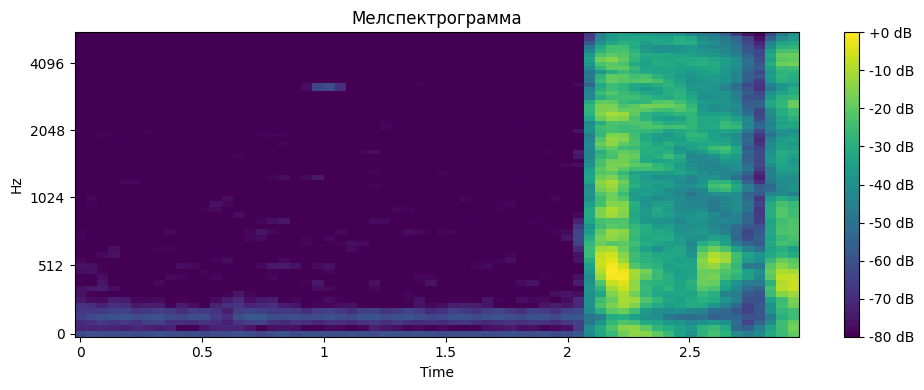

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cmap = "viridis"

img = librosa.display.specshow(
    sample_x[0].numpy(force=True),
    sr=sample_rate,
    fmax=sample_rate // 2,
    ax=ax,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax.set(title='Мелспектрограмма')
ax.label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.tight_layout()
plt.show()

In [40]:
from torch.utils.data import DataLoader

In [41]:
train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=num_workers)

In [42]:
import time
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score, classification_report
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

In [43]:
torch.use_deterministic_algorithms(False)

start_time = time.time()

n_epoch = 300
set_random_state(random_state)
network = FinalNetwork(num_classes=41).to(device)

print(f"Model device: {next(network.parameters()).device}")

optimizer = optim.AdamW(
    network.parameters(),
    lr=0.0005,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=20,
    eta_min=1e-6
)

plateau_scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.7,
    patience=12,
    min_lr=1e-7
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.15)

train_loss = []
val_loss = []
train_f1 = []
val_f1 = []

for e in range(n_epoch):
    print(f'epoch #{e+1}')

    # Train phase
    network.train()
    epoch_loss = 0
    all_preds = []
    all_targets = []

    for i_batch, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = network(x)

        loss = criterion(output, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=0.5)
        optimizer.step()

        epoch_loss += loss.item()
        preds = output.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

    # Calculate metrics
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    train_f1_score = f1_score(all_targets, all_preds, average='weighted')

    train_loss.append(epoch_loss / len(train_loader))
    train_f1.append(train_f1_score)

    print(f'[train] mean loss: {train_loss[-1]:.4f}')
    print(f'[train] F1-score:  {train_f1_score:.4f}')

    # Validation phase
    network.eval()
    val_loss_epoch = 0
    all_val_preds = []
    all_val_targets = []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            output = network(x)
            loss = criterion(output, y)
            val_loss_epoch += loss.item()

            preds = output.argmax(dim=1)
            all_val_preds.append(preds.cpu())
            all_val_targets.append(y.cpu())

    all_val_preds = torch.cat(all_val_preds).numpy()
    all_val_targets = torch.cat(all_val_targets).numpy()
    val_f1_score = f1_score(all_val_targets, all_val_preds, average='weighted')

    val_loss.append(val_loss_epoch / len(val_loader))
    val_f1.append(val_f1_score)

    print(f'[val] mean loss:   {val_loss[-1]:.4f}')
    print(f'[val] F1-score:    {val_f1_score:.4f}')

    cosine_scheduler.step()
    plateau_scheduler.step(val_f1_score)

Model device: cuda:0
epoch #1
[train] mean loss: 3.6392
[train] F1-score:  0.0485
[val] mean loss:   3.4061
[val] F1-score:    0.0426
epoch #2
[train] mean loss: 3.4339
[train] F1-score:  0.0700
[val] mean loss:   3.2524
[val] F1-score:    0.0862
epoch #3
[train] mean loss: 3.3368
[train] F1-score:  0.0865
[val] mean loss:   3.2191
[val] F1-score:    0.1065
epoch #4
[train] mean loss: 3.2721
[train] F1-score:  0.1061
[val] mean loss:   3.0685
[val] F1-score:    0.1589
epoch #5
[train] mean loss: 3.1910
[train] F1-score:  0.1237
[val] mean loss:   3.0350
[val] F1-score:    0.1718
epoch #6
[train] mean loss: 3.1301
[train] F1-score:  0.1427
[val] mean loss:   2.9318
[val] F1-score:    0.1928
epoch #7
[train] mean loss: 3.0861
[train] F1-score:  0.1693
[val] mean loss:   2.8637
[val] F1-score:    0.2362
epoch #8
[train] mean loss: 3.0249
[train] F1-score:  0.2001
[val] mean loss:   2.8093
[val] F1-score:    0.2584
epoch #9
[train] mean loss: 2.9541
[train] F1-score:  0.2227
[val] mean los

In [44]:
base_folder = "/content/drive/MyDrive/test"
test_folder = path.join(base_folder, "test")
test_pickle = path.join(base_folder, "test.pickle")
test_labels = os.path.join(base_folder, "sample_submission.csv")


extract_log_mel_feats(
    SetType.TEST,
    test_labels,
    test_folder,
    test_pickle,
    labels_pickle,
    sample_rate,
    n_fft,
    hop_length,
    n_mels
)
test_data = pickle.load(open(test_pickle, "rb"))

x_test = []
filenames = []
for row in test_data:
    feature = prepare_shape(row['feature'])
    x_test.append(feature)
    filenames.append(row['fname'])

x_test = np.asarray(x_test)
test_dset = EventDetectionDataset(x_test, device=device)
test_loader = DataLoader(test_dset, batch_size=41, shuffle=False, num_workers=num_workers)

3790it [07:58,  7.92it/s]


In [45]:
network.eval()
predictions = []

with torch.no_grad():
    for i_batch, sample_batched in enumerate(test_loader):
        x = sample_batched
        output = network(x)
        pred = output.argmax(axis=1)
        predictions.extend(pred.cpu().numpy())

predicted_labels = [id_to_label[pred] for pred in predictions]
submission_template = pd.read_csv(os.path.join(base_folder, test_labels))
prediction_dict = dict(zip(filenames, predicted_labels))
submission_template['label'] = submission_template['fname'].map(prediction_dict)

submission_file = path.join(base_folder, "submission.csv")
submission_template.to_csv(submission_file, index=False)

print("\nПервые 5 строк:")
print(submission_template.head())

print("\nРаспределение предсказанных меток:")
print(submission_template['label'].value_counts())


Первые 5 строк:
                      fname            label
0  973a8b381d1875ebe120.wav            Knock
1  052e1cbeb4391d6af234.wav  Acoustic_guitar
2  16eb98d96319450e0949.wav            Knock
3  ff13c136c04f274229a5.wav            Knock
4  b458211304f7a14b29b2.wav            Cough

Распределение предсказанных меток:
label
Writing                  157
Applause                 143
Tearing                  138
Saxophone                136
Violin_or_fiddle         136
Bass_drum                134
Oboe                     134
Laughter                 128
Flute                    121
Cello                    120
Double_bass              119
Fireworks                119
Fart                     118
Trumpet                  117
Bark                     114
Clarinet                 113
Acoustic_guitar          113
Knock                    110
Snare_drum               108
Hi-hat                   107
Gong                     104
Shatter                  100
Cough                     98
Burp